In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## 讀檔

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Keefe, Mr. Arthur",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
df_train.head()

## 進行Exploratory data analysis

### 初步的pairplot和heatmap看大趨勢，誰跟survived最有關係

In [ ]:
#可藉由pairplot先看出哪些群體存活率較高，之後feature engineering時將那些群體分離出來
#pairplot中只看得到continuous variables
sns.pairplot(df_train, hue='Survived')

In [ ]:
#heatmap也只有continuous variables
sns.heatmap(df_train.corr(), annot = True, fmt = '.2g', vmax = 1, vmin = -1, center = 0,
cmap='coolwarm', square= True, mask = np.triu(df_train.corr()))

### pairplot和heatmap裡看不到的categorical features就單獨做圖來看

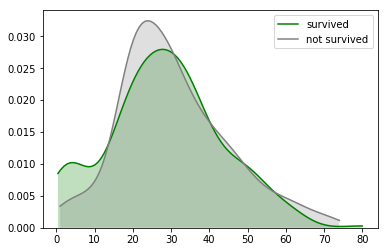

In [17]:
#kdeplot: for continuous variables
sns.kdeplot(df_train.loc[df_train.Survived==1,'Age'],
               color='g',
               shade=True, 
               label='survived',cut=0)
sns.kdeplot(df_train.loc[df_train['Survived']==0,'Age'],
               color='gray',
               shade=True, 
               label='not survived',cut=0)

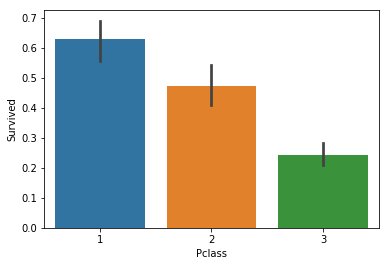

In [21]:
#barplot: for categorical variables
sns.barplot(x=df_train['Pclass'], y=df_train['Survived'])

## Feature Engineering


In [ ]:
#combine training and test set
df_all = pd.concat([df_train,df_test], axis=0).reset_index()
df_all.describe(include='all')

### Sex

In [ ]:
#encoding sex
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_all['Sex'])
df_all['Sex']=le.transform(df_all['Sex'])

df_all

### Name

In [ ]:
#converting name into title
df_all['title']=[ele.split(',')[1].split('.')[0].strip() for ele in df_all['Name']]

In [ ]:
#reduce title categories
new_title=[]
for i in df_all['title']:
    if i in ['Don','Rev','Dr','Mme','Ms','Major','Lady','Sir','Mlle','Col','Capt','the Countess','Jonkheer', 'Dona']:
        new_title.append('Rare')
    else:
        new_title.append(i)

df_all['new_title'] = new_title

In [ ]:
#convert title into dummy variables
df_all = pd.get_dummies(df_all, columns='new_title')


In [ ]:
df_all = df_all.drop(['title','Name'], axis=1)

### Fare

In [ ]:
#fillinf missing value for fare
df_all['Fare'] = df_all['Fare'].fillna(df_all['Fare'].median())

In [ ]:
#Create intervals for fare feature
df_all['Fare_band'] = pd.qcut(df_all['Fare'],5,labels=['0','1','2','3','4']).astype(int)

In [ ]:
df_all = df_all.drop('Fare', axis=1)

### Age

In [ ]:
#filling age missing value/ Using Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
age_X_known = df_all.loc[df_all['Age'].notnull()].drop(['index', 'PassengerId','Survived','Ticket','Cabin','Age','Embarked'],axis=1)
age_y_known = df_all.loc[df_all['Age'].notnull(),'Age']

In [ ]:
age_X_unknown = df_all.loc[df_all['Age'].isnull()].drop(['index', 'PassengerId','Survived','Ticket','Cabin','Age','Embarked'],axis=1)

In [ ]:
rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)

In [ ]:
rfr.fit(age_X_known, age_y_known)

In [ ]:
predicted_age = rfr.predict(age_X_unknown)

In [ ]:
age_predicted_df = pd.DataFrame(predicted_age)

In [ ]:
df_all.loc[(df_all['Age'].isnull()), 'Age' ] = predicted_age

In [ ]:
# Converting age into different intervals
Age_band = []
for i in df_all['Age']:
    if i<=16:
        Age_band.append(0)
    else:
        Age_band.append(1)
df_all['Age_band'] = Age_band

In [ ]:
df_all = df_all.drop(['Age'], axis=1)

### Family Size

In [ ]:
df_all['Family_size'] = df_all['SibSp']+df_all['Parch']
df_all = df_all.drop(['SibSp','Parch'], axis=1)

In [ ]:
# creating 'is_alone' feature
is_alone=[]
for i in df_all['Family_size']:
    if i==0:
        is_alone.append(1)
    else:
        is_alone.append(0)
is_alone_df = pd.DataFrame(is_alone)
df_all['is_alone'] = is_alone_df

In [ ]:
df_all = df_all.drop(['Family_size'], axis=1)

### Ticket, cabin, passenger ID, Name

In [ ]:
#drop ticket, cabin, passenger ID
df_all = df_all.drop(['Ticket','Cabin','PassengerId'], axis=1)


### Embarked

In [ ]:
#filling Embarked missing value
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [ ]:
#converting 'Embarked' column into one-hot form
df_all = pd.get_dummies(df_all,columns=['Embarked'])

In [ ]:
df_all = df_all.drop('index', axis=1)

In [ ]:
df_all.describe()

### Pclass

In [ ]:
is_3rdclass=[]
for i in df_all['Pclass']:
    if i==3:
        is_3rdclass.append(1)
    else:
        is_3rdclass.append(0)
df_all['is_3rdclass'] = is_3rdclass

In [ ]:
df_all = df_all.drop('Pclass', axis=1)

* 到以上為止，EDA和feature engineering的部分可以寫在data analysis裡面
* feature engineering做完之後，可以把每一個feature都跟類別做圖(Survived)，看每一個feature與類別之間的關係是什麼，這些圖可以放在results

### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
df_train = df_all.iloc[0:891,:]
df_test = df_all.iloc[891:,:] #for submission use

In [ ]:
X = df_train.drop('Survived',axis=1)
y = df_train['Survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state=0)
len(X_train)
len(X_test)

## Running model I - Random Forest
* Tree models does not require standardization

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion = 'gini', n_estimators=180, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rfc.fit(X_train, y_train)

In [ ]:
rfc_pred = rfc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, rfc_pred))
print('\n')
print(classification_report(y_test, rfc_pred))

In [ ]:
#plotting important features and relative importance between features
importances = rfc.feature_importances_
features = X_train.columns
feat_matrix = pd.DataFrame({'importances':importances, 'features':features})
sorted_feat = feat_matrix.sort_values(by='importances', ascending = False)

In [ ]:
sns.barplot(x='importances', y='features', data = sorted_feat, palette='pastel')

In [ ]:
# model improvement
X_train = X_train.drop(['Pclass','Family_size','Embarked_C','Embarked_Q','Embarked_S'], axis=1)

In [ ]:
X_test = X_test.drop(['Pclass','Family_size','Embarked_C','Embarked_Q','Embarked_S'], axis=1)

In [ ]:
rfc2 = RandomForestClassifier(criterion = 'gini', n_estimators=175)
rfc2.fit(X_train, y_train)

In [ ]:
rfc2_pred = rfc2.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, rfc2_pred))
print('\n')
print(classification_report(y_test, rfc2_pred))

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion = 'gini')
dtc.fit(X_train, y_train)

In [ ]:
dtc_pred = dtc.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, dtc_pred))
print('\n')
print(classification_report(y_test, dtc_pred))

## Running Model II - Logistics Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_test)

In [ ]:
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
scaled_X_train
scaled_X_test

In [ ]:
scaled_train = pd.DataFrame(scaled_X_train, columns = X_train.columns)
scaled_test = pd.DataFrame(scaled_X_test, columns = X_test.columns)

In [ ]:
scaled_train

In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear',
                            penalty= 'l1',random_state = 42)
logreg.fit(scaled_train,y_train)                                                    

In [ ]:
logreg_pred = logreg.predict(scaled_test)

In [ ]:
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))

## Running Model III -  SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='poly', C=1, degree=3)
svm.fit(scaled_train,y_train)

In [ ]:
svm_pred = svm.predict(scaled_test)

In [ ]:
print(confusion_matrix(y_test, svm_pred))
print('\n')
print(classification_report(y_test, svm_pred))

## Reviewing the test set

In [ ]:
df_test

## Predicting the test set

In [ ]:
def prediction(model, test_set):
    model_pred = model.predict(test_set.drop('Survived', axis=1))
    passengerId = pd.read_csv('test.csv')['PassengerId']
    submission = pd.DataFrame({'PassengerId':passengerId, 'Survived':model_pred})
    submission['Survived'] = submission['Survived'].astype(int)
    submission.to_csv('submission.csv', index=False)

In [ ]:
prediction(rfc,df_test)

In [ ]:
df_test2 = df_test.drop(['Pclass','Family_size','Embarked_C','Embarked_Q','Embarked_S'], axis=1)

In [ ]:
prediction(logreg, df_test)

In [ ]:
df_test2

### Predicting only females live

In [ ]:
output = []
for i in df_test['Sex']:
    if i ==0:
        output.append(1)
    else:
        output.append(0)
output_df = pd.DataFrame({'PassengerId':pd.read_csv('test.csv')['PassengerId'],'Survived':output})

In [ ]:
output_df

In [ ]:
sns.barplot(x='Survived', data=output_df)